In [1]:
from pre_processing import *
from feature_selection import *
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error
import joblib
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from scipy.stats import iqr
from improved_models import ImprovedLinearRegressor
from statistics import mean
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
pd.set_option("display.max_columns", None)

## Data processing
Load data in a single dataframe and split into train and test

In [2]:
PATH = './Train/Train'

df = load_general(PATH)
df_train, df_test = train_test_split(df)

#has_nan(df_train)
df

,station,latitude,longitude,numDocks,timestamp,year,month,day,hour,weekday,weekhour,isHoliday,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,precipitation.l.m2,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
0,266,39.492946,-0.401981,15,1.412114e+09,2014,10,1,0,Wednesday,49,0,11.3,3.2,67.5,21.3,85.0,855.3,0.0,NaN,NaN,NaN,NaN,NaN,5.0
1,266,39.492946,-0.401981,15,1.412118e+09,2014,10,1,1,Wednesday,50,0,1.6,0.0,157.5,21.1,86.0,1000.6,0.0,NaN,NaN,NaN,NaN,NaN,6.0
2,266,39.492946,-0.401981,15,1.412122e+09,2014,10,1,2,Wednesday,51,0,1.6,0.0,112.5,20.9,86.0,880.6,0.0,NaN,NaN,NaN,NaN,NaN,5.0
3,266,39.492946,-0.401981,15,1.412125e+09,2014,10,1,3,Wednesday,52,0,0.0,0.0,146.3,20.4,88.0,859.8,0.0,5.0,NaN,NaN,NaN,NaN,5.0
4,266,39.492946,-0.401981,15,1.412129e+09,2014,10,1,4,Wednesday,53,0,6.4,3.2,157.5,20.3,87.0,898.1,0.0,6.0,NaN,NaN,NaN,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55870,234,39.484848,-0.362137,18,1.414778e+09,2014,10,31,19,Friday,116,0,9.7,4.8,22.5,20.2,80.0,1023.5,0.0,4.0,7.00,15.25,7.00,15.25,17.0
55871,234,39.484848,-0.362137,18,1.414782e+09,2014,10,31,20,Friday,117,0,6.4,1.6,337.5,20.2,82.0,1023.9,0.0,11.0,8.75,16.25,8.75,16.25,13.0
55872,234,39.484848,-0.362137,18,1.414786e+09,2014,10,31,21,Friday,118,0,3.2,0.0,315.0,20.0,83.0,1024.0,0.0,17.0,2.25,14.00,2.25,14.00,15.0
55873,234,39.484848,-0.362137,18,1.414789e+09,2014,10,31,22,Friday,119,0,0.0,0.0,146.3,19.3,84.0,1024.4,0.0,17.0,-0.50,14.75,-0.50,14.75,17.0


Perform data processing and basic feature selection

In [3]:
#drop instance where there's no number of bikes
df = drop_nan_bikes(df)

# replaces days with numbers
df = pd.get_dummies(df,columns=['weekday'])

df_train, df_test = train_test_split(df, test_size=0.2)

#replaces NaN using imputer
df_train = nan_impute(df_train)
df_test = nan_impute(df_test)

#removes features with zero variance
df_train = var_transform(df_train)
df_test = var_transform(df_test)

#has_nan(df_test)

In [4]:
df_train

,station,latitude,longitude,numDocks,timestamp,day,hour,weekhour,isHoliday,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,242.0,39.467937,-0.331817,15.0,1.414490e+09,28.0,11.0,36.0,0.0,6.4,1.6,157.5,21.8,68.0,1018.1,7.0,-4.666667,3.00,-4.666667,3.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,215.0,39.465974,-0.368338,20.0,1.413263e+09,14.0,7.0,32.0,0.0,19.3,9.7,180.0,16.7,72.0,1006.8,5.0,-3.000000,1.00,-3.000000,1.00,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,215.0,39.465974,-0.368338,20.0,1.412680e+09,7.0,13.0,38.0,0.0,30.6,12.9,202.5,26.9,43.0,1011.1,8.0,-0.200000,8.00,-0.200000,8.00,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,207.0,39.468935,-0.379815,20.0,1.413868e+09,21.0,7.0,32.0,0.0,6.4,0.0,202.5,19.1,60.0,1020.7,1.0,3.000000,4.50,3.000000,4.50,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,270.0,39.445428,-0.393106,20.0,1.412168e+09,1.0,15.0,64.0,0.0,22.5,12.9,67.5,23.3,76.0,997.4,5.0,-0.200000,6.00,-0.200000,6.00,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44635,222.0,39.461261,-0.347921,20.0,1.414613e+09,29.0,21.0,70.0,0.0,6.4,1.6,67.5,19.6,86.0,1019.5,16.0,10.000000,15.25,10.000000,15.25,16.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44636,273.0,39.494136,-0.406020,16.0,1.413000e+09,11.0,6.0,127.0,0.0,14.5,8.0,202.5,20.7,69.0,1012.4,8.0,-1.000000,3.00,-1.000000,3.00,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
44637,259.0,39.465639,-0.396839,15.0,1.414422e+09,27.0,16.0,17.0,0.0,22.5,9.7,22.5,21.9,75.0,1020.6,1.0,0.000000,2.00,0.000000,2.00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
44638,246.0,39.489406,-0.386738,19.0,1.412910e+09,10.0,5.0,102.0,0.0,6.4,3.2,180.0,20.2,76.0,1010.7,1.0,1.000000,5.00,1.000000,5.00,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_train['isWorkingTime'] = df_train.apply(feat,axis=1)
df_train['occupancy_3h_ago'] = df_train.apply(occupancy,axis=1)
df_test['isWorkingTime'] = df_test.apply(feat,axis=1)
df_test['occupancy_3h_ago'] = df_test.apply(occupancy,axis=1)

Find which feature has highest correlation with bikes

In [6]:
corr_matrix = correl(df_train)
print(corr_matrix['bikes'].sort_values(ascending=False).head(25))

bikes                          1.000000
bikes_3h_ago                   0.672968
full_profile_bikes             0.650277
short_profile_bikes            0.650277
occupancy_3h_ago               0.623190
longitude                      0.281673
full_profile_3h_diff_bikes     0.258710
short_profile_3h_diff_bikes    0.258710
latitude                       0.197029
numDocks                       0.119303
hour                           0.030329
temperature.C                  0.027575
station                        0.027232
isWorkingTime                  0.021446
isHoliday                      0.019876
weekhour                       0.014921
weekday_Sunday                 0.014263
windMaxSpeed.m.s               0.011598
relHumidity.HR                 0.011597
weekday_Wednesday              0.011066
windMeanSpeed.m.s              0.010858
weekday_Tuesday                0.009739
weekday_Saturday               0.009646
weekday_Friday                 0.006634
weekday_Thursday               0.004985


<AxesSubplot:xlabel='short_profile_3h_diff_bikes', ylabel='bikes'>

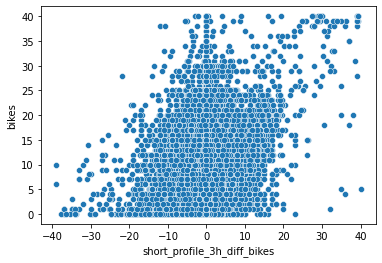

In [7]:
sns.scatterplot(data=df_train, x='short_profile_3h_diff_bikes', y='bikes')

Find inter-feature correlation and drop features with a correlation higher than 0.95

Obviously windmean and windmax are positively correlated.

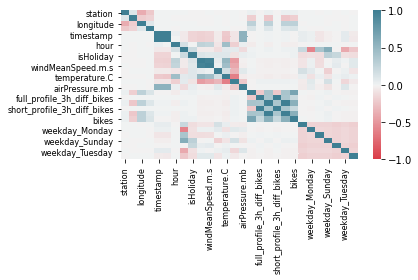

In [61]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
ax = sns.heatmap(df_train.corr(), vmin=-1.0, vmax=1.0, cmap=cmap)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)
#ax.set_title('Correlation matrix of the general dataset', fontsize=8)
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('heatmap.eps')

In [7]:
dropped = high_correl(df_train, 0.95)
dropped = high_correl(df_test, 0.95)
print(dropped)

['day', 'windMeanSpeed.m.s', 'short_profile_3h_diff_bikes', 'short_profile_bikes']


In [28]:
# sorted(df_train)
# Q1 = df_train.quantile(q=0.25)
# Q3 = df_train.quantile(q=0.75)
# IQR = Q3-Q1
# IQR
# df_out = df_train[~((df_train < (Q1 - 1.5 * IQR)) |(df_train > (Q3 + 1.5 * IQR))).any(axis=1)]

In [29]:
# df_out

In [10]:
sns.lmplot(data= df_train, x='bikes_3h_ago', y='bikes')

NameError: name 'sns' is not defined

Plot histograms to see whether input is Gaussian

In [11]:
df_train.hist()

NameError: name 'df_train' is not defined

In [12]:
df_train['bikes'].hist()

NameError: name 'df_train' is not defined

Let's now investigate some categorical features

In [14]:
sns.boxplot(data = df_train, x = 'temperature.C', palette="Set3")

NameError: name 'sns' is not defined

In [15]:
sns.boxplot(data = df_train, x = 'isHoliday', y = 'bikes', palette="Set3")

NameError: name 'sns' is not defined

In [16]:
sns.boxplot(data = df_train, x = 'hour', y = 'bikes', palette="Set3")

NameError: name 'sns' is not defined

## Model selection

Scale the features and impute missing data

In [8]:
#store features and target in two different dataframes
X_train = df_train.loc[:, df_train.columns != 'bikes']
Y_train = df_train['bikes']
X_train

,station,latitude,longitude,numDocks,timestamp,hour,weekhour,isHoliday,windMaxSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,isWorkingTime,occupancy_3h_ago
0,242.0,39.467937,-0.331817,15.0,1.414490e+09,11.0,36.0,0.0,6.4,157.5,21.8,68.0,1018.1,7.0,-4.666667,3.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.466667
1,215.0,39.465974,-0.368338,20.0,1.413263e+09,7.0,32.0,0.0,19.3,180.0,16.7,72.0,1006.8,5.0,-3.000000,1.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.250000
2,215.0,39.465974,-0.368338,20.0,1.412680e+09,13.0,38.0,0.0,30.6,202.5,26.9,43.0,1011.1,8.0,-0.200000,8.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.400000
3,207.0,39.468935,-0.379815,20.0,1.413868e+09,7.0,32.0,0.0,6.4,202.5,19.1,60.0,1020.7,1.0,3.000000,4.50,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.050000
4,270.0,39.445428,-0.393106,20.0,1.412168e+09,15.0,64.0,0.0,22.5,67.5,23.3,76.0,997.4,5.0,-0.200000,6.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44635,222.0,39.461261,-0.347921,20.0,1.414613e+09,21.0,70.0,0.0,6.4,67.5,19.6,86.0,1019.5,16.0,10.000000,15.25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.800000
44636,273.0,39.494136,-0.406020,16.0,1.413000e+09,6.0,127.0,0.0,14.5,202.5,20.7,69.0,1012.4,8.0,-1.000000,3.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.500000
44637,259.0,39.465639,-0.396839,15.0,1.414422e+09,16.0,17.0,0.0,22.5,22.5,21.9,75.0,1020.6,1.0,0.000000,2.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.066667
44638,246.0,39.489406,-0.386738,19.0,1.412910e+09,5.0,102.0,0.0,6.4,180.0,20.2,76.0,1010.7,1.0,1.000000,5.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.052632


In [9]:
#unscaled test set (to see predictions)
X_test = df_test.loc[:, df_test.columns != 'bikes']
Y_test= df_test['bikes']

In [10]:
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [12]:
sns.boxplot(data = df_train, x = 'hour', y = 'bikes', palette="Set3")

NameError: name 'df_train' is not defined

In [21]:
# improved = ImprovedLinearRegressor(model='short_full')
# improved.fit(X_train,Y_train)


In [23]:
# prediction = improved.predict(X_test)
# error = mean_absolute_error(predictio, Y_test)
# error

ValueError: matrices are not aligned

Experiment with baseline methods

In [11]:
# pipelines = [('Linear regression', Pipeline([('Scaler', MinMaxScaler()), ("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('LR',LinearRegression())])),
#              ('Ridge', Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('L2',Ridge())])),
#              ('DecisionTree',Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('DT',DecisionTreeRegressor())])),
#              ('RandomForest',Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('RF',RandomForestRegressor())])),
#              ('KNN',Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('KNN',KNeighborsRegressor())])),
#            #  ('SVR',Pipeline([('Scaler', RobustScaler()),('SVR',SVR())])),
#              ('GradientBoosting', Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('GBM', GradientBoostingRegressor())]))]

pipelines = [('LinearRegression',LinearRegression()),
             ('Ridge',Ridge(alpha=0.01)),
             ('DecisionTrees',DecisionTreeRegressor()),
             ('RandomForest',RandomForestRegressor()),
             ('GradientBoosting',lgb.LGBMRegressor()),
             #('XGB',XGBRegressor()),
             ('KNN',KNeighborsRegressor()),
             ('SVR',SVR())]
             #('GBM', GradientBoostingRegressor())]
scores = []
for model, pipeline in pipelines:
    cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f'Model {model} : {cv_scores.mean()}\n')
    scores.append(cv_scores.mean())
print("\n")

Model LinearRegression : -2.8280416377117423

Model Ridge : -2.8280419659467193

Model DecisionTrees : -2.906317204301075

Model RandomForest : -2.179182347670251

Model GradientBoosting : -2.3137806038564266

Model KNN : -2.567177419354839



KeyboardInterrupt: 

<AxesSubplot:>

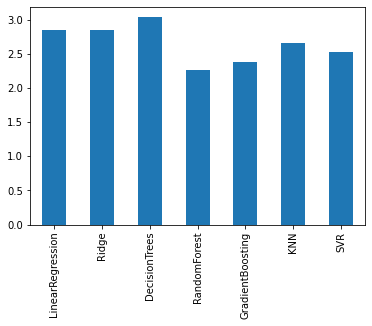

In [35]:
scores = pd.Series(scores, index=[model for model, pipeline in pipelines])

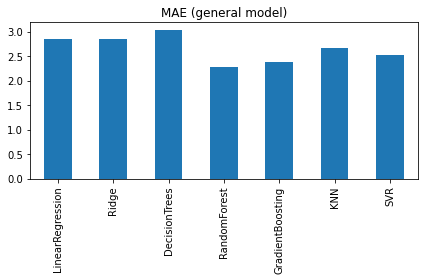

In [39]:
ax = scores.abs().plot.bar(title='MAE (general model)')
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('general_models.eps')

As it is possible to see RandomForest and SVR are the ones that perform better. Let's try to tune Random Forest first


Try to tune Ridge regression

In [18]:
alpha = {'alpha': np.arange(0, 1, 0.01)}
grid_search = GridSearchCV(Ridge(), param_grid=alpha, scoring='neg_mean_absolute_error', n_jobs=3, cv=10)

grid_search.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=Ridge(), n_jobs=3,
             param_grid={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
             scoring='neg_mean_absolute_error')

In [20]:
grid_search.best_estimator_.coef_

array([ 3.35703069e-01, -1.42792401e-01,  5.63511719e-01,  1.87317570e-01,
       -4.48659811e-02, -3.43139186e-03,  2.35619909e-02,  9.62847798e-02,
       -5.45831911e-03, -2.04032853e-02, -3.56288339e-02, -4.12066738e-02,
        5.91778751e-04,  6.14625176e+00,  9.74592943e-01,  1.16808725e+00,
        8.57311768e-02, -1.00419004e-02, -1.55165606e-02, -1.65064920e-02,
       -2.54631920e-02, -2.19825789e-02,  3.77954745e-03, -1.20667585e-02,
        4.49404292e-01])

In [22]:
# param_grid_forest = {#'n_estimators': np.arange(1, 1001, 100),
#           'max_features': ['auto', 'sqrt'],
#           'max_depth': list(np.arange(10, 70, 10)),
#           'min_samples_split': list(np.arange(1, 22, 5)),
#           'min_samples_leaf': list(np.linspace(0.1, 0.5, 5, endpoint=False)) + [1, 2, 5, 7, 10],
#           'bootstrap' : [True, False]# 'min_samples_split': [2, 5, 10],
#           # 'min_samples_leaf': [1, 2, 4]
#          }

param_grid_forest = {#'n_estimators': np.arange(100, 2000, 500),
          'max_features': ['auto', 'sqrt'],
          'max_depth': list(np.arange(5, 70, 15)) + None,
          'min_samples_split': list(np.linspace(0.1, 1.0, 10, endpoint=True)) + [5, 10, 20],
          'min_samples_leaf': list(np.linspace(0.1, 0.5, 5, endpoint=True))+ [5, 10]
          # 'min_samples_split': [2, 5, 10],
          # 'min_samples_leaf': [1, 2, 4]
         }
tree_reg = RandomizedSearchCV(estimator = RandomForestRegressor(n_estimators=1000),
                              param_distributions = param_grid_forest, n_iter = 100,
                              verbose = 2, n_jobs = 3, cv=10, scoring='neg_mean_absolute_error')
print(f"Starting training...")
tree_reg.fit(X_train, Y_train)
joblib.dump(tree_reg.best_estimator_, "randomforest.joblib")
print(f'Best parameters for dataset are {tree_reg.best_params_}')
print(f'Best score is {tree_reg.best_score_}')

Starting training...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.7min


KeyboardInterrupt: 

In [28]:
forest = joblib.load("randomforest.joblib")
predictions = forest.predict(X_test)
#predictions = tree_reg.best_estimator_.predict(X_test)
test_error = mean_absolute_error(predictions, Y_test)
print(f"The MAE on the test set is {test_error}\n")

#sorted(dict(zip(X_train.columns, tree_reg.best_estimator_.feature_importances_)).items(), key=lambda x: x[1], reverse=True)

The MAE on the test set is 5.52184941908037



In [ ]:
model = RandomForestRegressor()
#model.set_params(**tree_reg.best_params_)
model.fit(X_train,Y_train)

In [ ]:
predictions = model.predict(X_test)
prediction = pd.DataFrame(predictions, columns=['bikes'], dtype='int32')
mean_absolute_error(prediction, Y_test)

In [ ]:
prediction = pd.DataFrame(predictions, columns=['bikes'], dtype='int32')
mean_absolute_error(prediction, Y_test)

Now tune LGB

In [11]:
#this cell is taken from https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761#Basic-end-to-end-training-of-a-LightGBM-model)
train_x, val_x, train_y, val_y = train_test_split(X_train, Y_train, test_size = 0.10, random_state=1)
fit_params={"early_stopping_rounds":30,
            "eval_metric" : 'mae',
            "eval_set" : [(val_x,val_y)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            #'verbose': 100,
            'categorical_feature': 'auto'}

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3



In [14]:
param_test ={#'learning_rate': [0.001, 0.01, 0.02, 0.05, 0.1],
             'num_leaves': np.arange(6,50,2),#sp_randint(6, 50),
             #'n_estimators': sp_randint(100,2000),
             #'learning_rate': np.arange(0.01,0.2,0.01),
             'max_depth': list(np.arange(3, 30, 2)),
             #'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
             'min_child_samples': np.arange(5,500,20),#sp_randint(5, 200),
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 3, 5, 7, 1e1, 1e2, 1e3, 1e4],
             #'min_data_in_leaf': sp_randint(1, 50),
             'subsample': sp_uniform(loc=0.2, scale=0.8),
             #'subsample' : [0.6, 0.7, 0.8, 0.9],
             #'colsample_bytree' : [0.6, 0.7, 0.8, 0.9],
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             #"max_bin": sp_randint(1, 512)
             # 'bagging_freq': sp_randint(1, 1000),
             # 'bagging_fraction': np.arange(0.1, 1, 0.1),
             }
#param_test = {'n_estimators': np.arange(10,100)}
model = lgb.LGBMRegressor(n_jobs=4)#, n_estimators=10000)

lgb_reg = RandomizedSearchCV(estimator = model,
                              param_distributions = param_test, n_iter = 200,
                              verbose = 2, cv=10, scoring='neg_mean_absolute_error')
print(f"Starting training...")
lgb_reg.fit(X_train,Y_train)#, **fit_params)#, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])#, **fit_params)
joblib.dump(lgb_reg.best_estimator_, "lgb.joblib")
print(f'Best parameters for dataset are {lgb_reg.best_params_}')
print(f'Best score is {lgb_reg.best_score_}')

Starting training...
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[CV] colsample_bytree=0.8302614080226599, max_depth=11, min_child_samples=85, min_child_weight=7, num_leaves=12, reg_alpha=100, reg_lambda=20, subsample=0.3145332092630776 
[CV]  colsample_bytree=0.8302614080226599, max_depth=11, min_child_samples=85, min_child_weight=7, num_leaves=12, reg_alpha=100, reg_lambda=20, subsample=0.3145332092630776, total=   0.2s
[CV] colsample_bytree=0.8302614080226599, max_depth=11, min_child_samples=85, min_child_weight=7, num_leaves=12, reg_alpha=100, reg_lambda=20, subsample=0.3145332092630776 
[CV]  colsample_bytree=0.8302614080226599, max_depth=11, min_child_samples=85, min_child_weight=7, num_leaves=12, reg_alpha=100, reg_lambda=20, subsample=0.3145332092630776, total=   0.2s
[CV] colsample_bytree=0.8302614080226599, max_depth=11, min_child_samples=85, min_child_weight=7, num_leaves=12, reg_alpha=100, reg_lambda=20, subsample=0.3145332092630776 
[CV]  colsample_byt

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  8.0min finished


In [62]:
params = {'objective': 'regression', 'learning_rate':0.05, 'colsample_bytree': 0.9472022124846666, 'min_child_samples': 150, 'min_child_weight': 0.01, 'num_leaves': 47, 'reg_alpha': 2, 'reg_lambda': 0.1, 'subsample': 0.2733937420820305}
train_dataset = lgb.Dataset(data=X_train,label=Y_train)
cv_results = lgb.cv(
        params,
        train_dataset,
        num_boost_round=10000,
        nfold=10,
        metrics='mae',
        early_stopping_rounds=30,
        verbose_eval=True,
        #callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)],
        # This is what I added
        stratified=False
        )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 40176, number of used features: 25
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 40176, number of used features: 25
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 40176, number of used features: 25
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003278 seconds.
You can set `forc

In [63]:
mean(cv_results['l1-mean'])

1.9960262208439268

In [64]:
#params = {'objective': 'regression', 'learning_rate':0.05, 'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 50, 'num_leaves': 48, 'min_child_weight': 10.0, 'min_child_samples': 45, 'max_depth': 15, 'colsample_bytree': 0.8}

final_model = lgb.train(
        params,
        train_dataset,
        num_boost_round=9025,
        #early_stopping_rounds=30
        #callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)],
        )
joblib.dump(final_model, 'lgb_fitted.joblib')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 44640, number of used features: 25
[LightGBM] [Info] Start training from score 7.428696


['lgb_fitted.joblib']

In [29]:
g_boosting = joblib.load("lgb.joblib")
predictions = g_boosting.predict(X_test)
#predictions = tree_reg.best_estimator_.predict(X_test)
# test_error = mean_absolute_error(predictions, Y_test)
# print(f"The MAE on the test set is {test_error}\n")
#
#
#sorted(dict(zip(X_train.columns, g_boosting.best_estimator_.feature_importances_)).items(), key=lambda x: x[1], reverse=True)

In [30]:
prediction = pd.DataFrame(predictions, columns=['bikes'], dtype='int32')
mean_absolute_error(prediction, Y_test)

2.378673835125448

In [ ]:
#best_params = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_samples': 32, 'min_child_weight': 0.001, 'num_leaves': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
final_model = lgb.LGBMRegressor(learning_rate=0.2)
#final_model.set_params(**g_boosting.best_params_)
final_model.set_params(**lgb_reg.best_params_)
final_model.fit(X_train,Y_train)
joblib.dump(final_model, 'lgb_fitted.joblib')


In [ ]:
predictions = pd.DataFrame(final_model.predict(X_test)).astype('int64')
mean_absolute_error(predictions,Y_test)

Try to do a stacked regressor with the Improved Linear Models

In [26]:

model1 = RandomForestRegressor()
#model1.set_params(**{'n_estimators': 600, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 95})

model2 = lgb.LGBMRegressor()
model2.set_params(**{'colsample_bytree': 0.4879932676754964, 'max_depth': 19, 'min_child_samples': 5, 'min_child_weight': 0.01, 'num_leaves': 48, 'reg_alpha': 10, 'reg_lambda': 0, 'subsample': 0.6829066015352835})

model3 = ImprovedLinearRegressor(model_name='full_temp')

In [27]:
final_model = StackingRegressor(final_estimator=Ridge(), estimators=[('forest',model1), ('lgb', model2), ('improved', model3)], cv=10)

final_model.fit(X_train, Y_train)
joblib.dump(final_model, 'stacking.joblib')

['stacking.joblib']

In [28]:
predictions = pd.DataFrame(final_model.predict(X_test)).astype('int64')
mean_absolute_error(predictions,Y_test)

2.3184587813620072